# 영화 필터링

- 이상한 영화들이 존재하여 제거해야함.

In [1]:
import pandas as pd

movie_metadata = pd.read_excel("cinemate_data_0511.xlsx")
final_metadata = pd.read_excel("final_metadata_with_overview_embeddings_ver5_0511.xlsx")

In [3]:
final_metadata

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,ordering,...,embedding_374,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383
0,tt31015344,A Traveler's Needs,Yeohaengjaui Pilyo,2024,90,Drama,6.5,75,nm0393254,1,...,0.016458,-0.023006,-0.050298,0.037739,-0.076090,-0.010432,-0.058701,0.017649,0.035267,-0.023228
1,tt30911335,Dog Days,Dogeudeijeu,2024,120,Drama,7.8,31,nm15730187,1,...,-0.034701,-0.008065,-0.024117,-0.003312,0.038821,-0.030186,0.019926,0.074339,-0.018989,0.055851
2,tt9682428,Night Swim,Night Swim,2024,98,"Horror,Thriller",4.7,12654,nm3241399,1,...,0.003738,-0.049932,-0.121888,-0.054388,-0.020564,0.050116,0.021484,0.052849,0.035944,0.025606
3,tt27802490,Exhuma,Pamyo,2024,134,"Horror,Mystery,Thriller",7.4,495,nm6940206,1,...,0.051392,-0.002096,0.044035,0.059909,-0.044593,-0.032423,0.081002,0.020807,0.021268,0.008938
4,tt27811040,The Roundup: Punishment,Beomjoedosi4,2024,109,"Action,Crime,Thriller",8.8,101,nm2441168,10,...,0.041042,-0.039577,0.034051,0.041895,-0.132000,-0.051895,0.089292,-0.132800,-0.011520,-0.006363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9520,tt0017409,So This Is Paris,So This Is Paris,1926,60,Comedy,7.1,746,nm0523932,1,...,-0.052198,-0.056215,-0.065513,0.068392,0.040504,-0.013506,-0.068042,0.001189,-0.021429,-0.103460
9521,tt0015064,The Last Laugh,Der letzte Mann,1924,88,Drama,8.0,15105,nm0003638,1,...,0.029271,-0.052846,0.032112,0.051352,-0.038684,-0.013877,0.074433,-0.020061,-0.008468,0.026134
9522,tt0014624,A Woman of Paris: A Drama of Fate,A Woman of Paris: A Drama of Fate,1923,82,"Drama,Romance",6.9,6104,nm0000122,10,...,0.018064,-0.050176,-0.045593,0.036943,-0.046362,-0.033189,-0.061279,-0.036766,0.073398,-0.105024
9523,tt0012806,Four Around the Woman,Vier um die Frau,1921,52,Drama,5.9,581,nm0000485,1,...,-0.047176,-0.100745,0.056739,0.063528,-0.031887,-0.028223,-0.002628,-0.041470,0.026425,0.023838


In [8]:
# movie_metadata 내에서 title이 영어이거나 한국어가 아닌 것들
movie_metadata[~(movie_metadata['title'].str.contains('[a-zA-Z]') | movie_metadata['title'].str.contains('[가-힣]'))]

,movie_id,rating,backdrop_path,original_title,title,release_date,poster_path,overview
66,797271,6.600,/wUdNZleFlH4f2u3LTMn1SwTZ6r.jpg,反击,反击,2021-02-15,/323HW02vWTuT2TG3yGVxwxxY3fs.jpg,NaN
86,1165250,7.000,/aOUUF5yID3AFMIgQIXc7tTCESBd.jpg,超级飞侠：乐迪加速,超级飞侠：乐迪加速,2023-07-08,/e4KwwGsXLY9JCbawVIySbgsPqZ7.jpg,NaN
96,1130963,4.000,NaN,מרחוק,מרחוק,2023-04-30,/mGHWW1ANu2FUcJUc4kmCabG7wC5.jpg,NaN
144,912770,4.900,/fcwBReQPrvhymJFrMY8MTXAVZk3.jpg,سكة طويلة,سكة طويلة,2022-08-25,/jZ58C9r3KJLdkyCTvRAvQh7tkI5.jpg,NaN
157,1024350,8.000,/7ziE2gWkSH0cNjjD9QfVVsYUuMX.jpg,ଦମନ,ଦମନ,2022-11-04,/vJnR7ubqodJUGzHPvNMbMvpcOiG.jpg,NaN
...,...,...,...,...,...,...,...,...
9224,933019,0.000,NaN,Гость с острова свободы,Гость с острова свободы,1963-06-04,/yqg4yFdPWnIECxpR0LDWRjYU3O6.jpg,NaN
9303,455872,6.000,NaN,二発目は地獄行きだぜ,二発目は地獄行きだぜ,1960-01-27,/xpWOkjDEZTEaXVgyshN1ofSZpbH.jpg,NaN
9318,83539,7.131,/o3vY0RJFGSvAJfqXJzuxhOWgFr2.jpg,Неотправленное письмо,Неотправленное письмо,1960-06-27,/cyCUvLKYKYADpAR3pnb2ynOqlXT.jpg,NaN
9352,84782,6.700,/bVzMUO0lXPuUBaAuNKErwzV5LVY.jpg,Дон Кихот,Дон Кихот,1957-05-23,/sNIDdG92Kt4o4dyTsbtsiTrr3mi.jpg,NaN


In [12]:
# movie_metadata 내에서 title이 영어이거나 한국어인 것들의 인덱스로 final_metadata에서 해당 데이터만 추출
final_metadata = final_metadata.iloc[movie_metadata[(movie_metadata['title'].str.contains('[a-zA-Z]') | movie_metadata['title'].str.contains('[가-힣]'))].index]

In [15]:
final_metadata.to_excel("final_metadata_with_overview_embeddings_only_eng_kor_0528.xlsx", index=False)

## 변경한 데이터의 장르 정보 확인

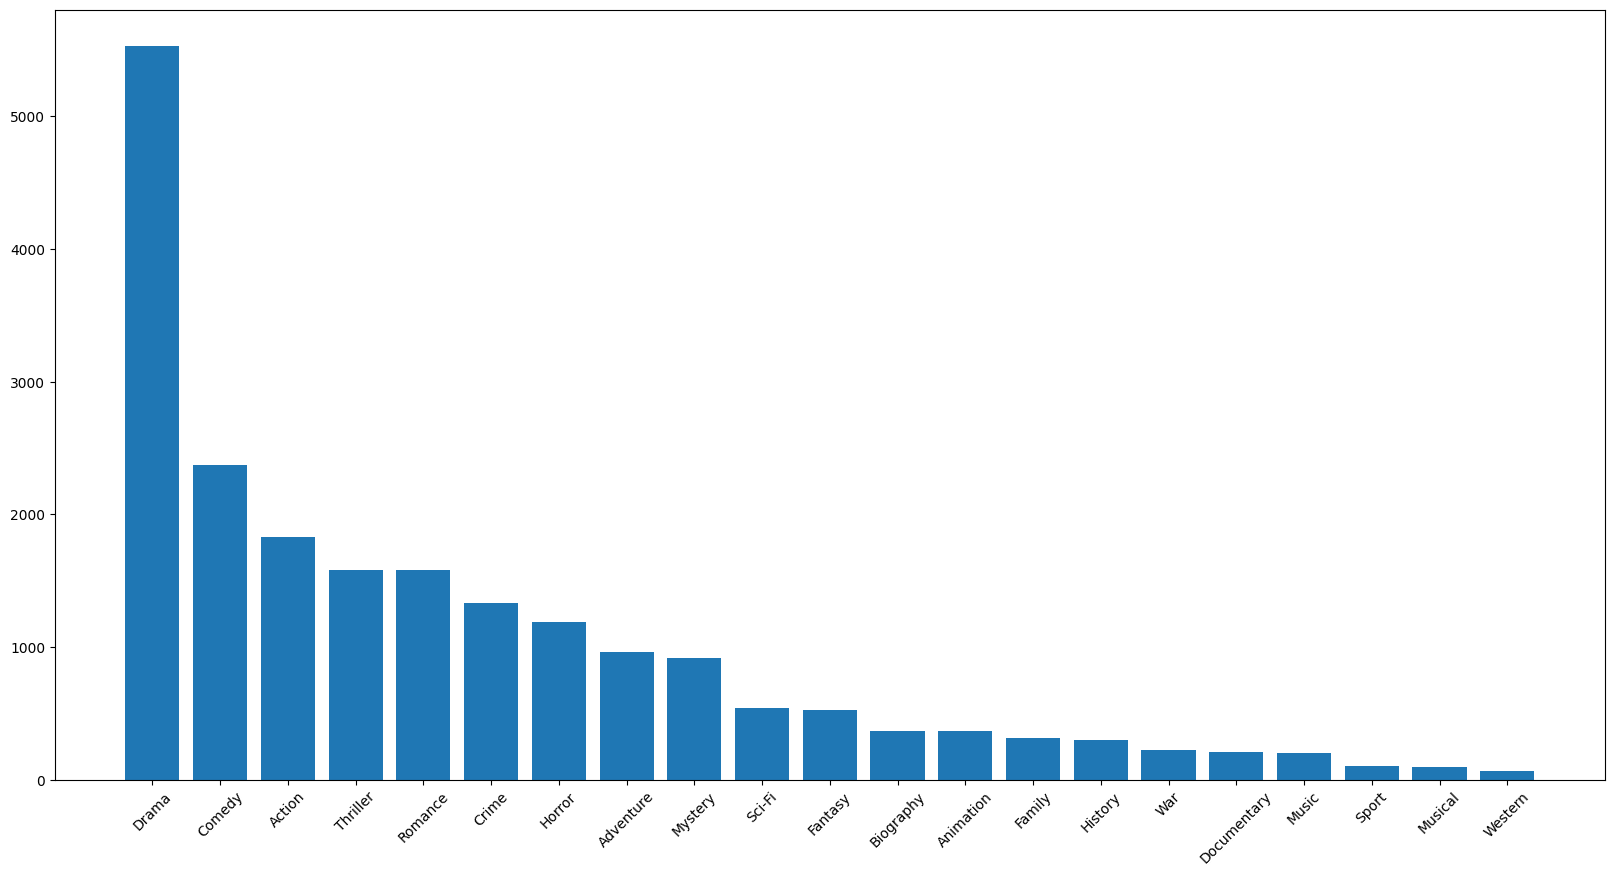

In [16]:
# 각 영화의 인덱스를 키로, 해당 영화의 장르를 값으로 가지는 딕셔너리 생성
movie_genres = {}
for index, row in final_metadata.iterrows():
    genres = row.iloc[5].split(',')  # ','로 장르 분리
    movie_genres[index] = set(genres)  # 장르 집합 생성하여 딕셔너리에 저장
# movie_genres
# 각 장르별 영화 개수 plot
import matplotlib.pyplot as plt

genre_count = {}
for genres in movie_genres.values():
    for genre in genres:
        if genre in genre_count:
            genre_count[genre] += 1
        else:
            genre_count[genre] = 1
genre_count = dict(sorted(genre_count.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(20, 10))
plt.bar(genre_count.keys(), genre_count.values())
plt.xticks(rotation=45)
plt.show()

In [17]:
genre_count

{'Drama': 5529,
 'Comedy': 2375,
 'Action': 1828,
 'Thriller': 1583,
 'Romance': 1577,
 'Crime': 1332,
 'Horror': 1189,
 'Adventure': 962,
 'Mystery': 919,
 'Sci-Fi': 541,
 'Fantasy': 526,
 'Biography': 364,
 'Animation': 363,
 'Family': 315,
 'History': 301,
 'War': 221,
 'Documentary': 207,
 'Music': 199,
 'Sport': 105,
 'Musical': 92,
 'Western': 66}

In [19]:
# final_metadata 초기화
final_metadata.reset_index(drop=True, inplace=True)

In [20]:
final_metadata

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,ordering,...,embedding_374,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383
0,tt31015344,A Traveler's Needs,Yeohaengjaui Pilyo,2024,90,Drama,6.5,75,nm0393254,1,...,0.016458,-0.023006,-0.050298,0.037739,-0.076090,-0.010432,-0.058701,0.017649,0.035267,-0.023228
1,tt30911335,Dog Days,Dogeudeijeu,2024,120,Drama,7.8,31,nm15730187,1,...,-0.034701,-0.008065,-0.024117,-0.003312,0.038821,-0.030186,0.019926,0.074339,-0.018989,0.055851
2,tt9682428,Night Swim,Night Swim,2024,98,"Horror,Thriller",4.7,12654,nm3241399,1,...,0.003738,-0.049932,-0.121888,-0.054388,-0.020564,0.050116,0.021484,0.052849,0.035944,0.025606
3,tt27802490,Exhuma,Pamyo,2024,134,"Horror,Mystery,Thriller",7.4,495,nm6940206,1,...,0.051392,-0.002096,0.044035,0.059909,-0.044593,-0.032423,0.081002,0.020807,0.021268,0.008938
4,tt27811040,The Roundup: Punishment,Beomjoedosi4,2024,109,"Action,Crime,Thriller",8.8,101,nm2441168,10,...,0.041042,-0.039577,0.034051,0.041895,-0.132000,-0.051895,0.089292,-0.132800,-0.011520,-0.006363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9299,tt0017409,So This Is Paris,So This Is Paris,1926,60,Comedy,7.1,746,nm0523932,1,...,-0.052198,-0.056215,-0.065513,0.068392,0.040504,-0.013506,-0.068042,0.001189,-0.021429,-0.103460
9300,tt0015064,The Last Laugh,Der letzte Mann,1924,88,Drama,8.0,15105,nm0003638,1,...,0.029271,-0.052846,0.032112,0.051352,-0.038684,-0.013877,0.074433,-0.020061,-0.008468,0.026134
9301,tt0014624,A Woman of Paris: A Drama of Fate,A Woman of Paris: A Drama of Fate,1923,82,"Drama,Romance",6.9,6104,nm0000122,10,...,0.018064,-0.050176,-0.045593,0.036943,-0.046362,-0.033189,-0.061279,-0.036766,0.073398,-0.105024
9302,tt0012806,Four Around the Woman,Vier um die Frau,1921,52,Drama,5.9,581,nm0000485,1,...,-0.047176,-0.100745,0.056739,0.063528,-0.031887,-0.028223,-0.002628,-0.041470,0.026425,0.023838


# 장르 one-hot encoding

In [21]:
genres_one_hot_encoded = final_metadata.genres.str.get_dummies(sep=',')
genres_one_hot_encoded

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9299,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9300,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9301,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
9302,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# 감독, 배우 one-hot encoding

In [22]:
unique_directors_combinations = final_metadata['directors'].unique()
# unique_directors_combinations.__len__()
unique_directors = set()

for combination in unique_directors_combinations:
    directors = combination.split(',')
    unique_directors.update(directors)

print(sorted(unique_directors))
directors_one_hot_encoded = final_metadata.directors.str.get_dummies(sep=',')
# final_metadata[directors_one_hot_encoded.sum(axis=1) > 1]
directors_one_hot_encoded

['\\N', 'nm0000005', 'nm0000008', 'nm0000019', 'nm0000033', 'nm0000037', 'nm0000040', 'nm0000041', 'nm0000056', 'nm0000076', 'nm0000078', 'nm0000080', 'nm0000086', 'nm0000095', 'nm0000108', 'nm0000110', 'nm0000116', 'nm0000118', 'nm0000122', 'nm0000123', 'nm0000126', 'nm0000127', 'nm0000128', 'nm0000134', 'nm0000142', 'nm0000149', 'nm0000154', 'nm0000158', 'nm0000165', 'nm0000180', 'nm0000184', 'nm0000185', 'nm0000186', 'nm0000195', 'nm0000198', 'nm0000200', 'nm0000217', 'nm0000229', 'nm0000230', 'nm0000231', 'nm0000233', 'nm0000243', 'nm0000247', 'nm0000255', 'nm0000264', 'nm0000265', 'nm0000269', 'nm0000277', 'nm0000316', 'nm0000318', 'nm0000320', 'nm0000338', 'nm0000339', 'nm0000341', 'nm0000343', 'nm0000361', 'nm0000362', 'nm0000367', 'nm0000382', 'nm0000386', 'nm0000389', 'nm0000399', 'nm0000406', 'nm0000416', 'nm0000419', 'nm0000425', 'nm0000428', 'nm0000431', 'nm0000436', 'nm0000454', 'nm0000455', 'nm0000464', 'nm0000466', 'nm0000484', 'nm0000485', 'nm0000487', 'nm0000490', 'nm0

,\N,nm0000005,nm0000008,nm0000019,nm0000033,nm0000037,nm0000040,nm0000041,nm0000056,nm0000076,...,nm9931859,nm9935672,nm9938454,nm9952702,nm9952703,nm9959340,nm9970487,nm9980622,nm9986784,nm9989001
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9299,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
unique_actors_combinations = final_metadata['actors'].unique()
unique_actors = set()

for combination in unique_actors_combinations:
    actors = combination.split(',')
    unique_actors.update(actors)

print(sorted(unique_actors))
actors_one_hot_encoded = final_metadata.actors.str.get_dummies(sep=',')
# final_metadata[actors_one_hot_encoded.sum(axis=1) > 1]
actors_one_hot_encoded

['nm0000001', 'nm0000002', 'nm0000003', 'nm0000004', 'nm0000006', 'nm0000007', 'nm0000008', 'nm0000009', 'nm0000010', 'nm0000011', 'nm0000012', 'nm0000013', 'nm0000014', 'nm0000015', 'nm0000017', 'nm0000018', 'nm0000020', 'nm0000021', 'nm0000022', 'nm0000023', 'nm0000024', 'nm0000026', 'nm0000027', 'nm0000030', 'nm0000031', 'nm0000032', 'nm0000034', 'nm0000037', 'nm0000038', 'nm0000039', 'nm0000042', 'nm0000044', 'nm0000045', 'nm0000046', 'nm0000047', 'nm0000048', 'nm0000051', 'nm0000052', 'nm0000053', 'nm0000054', 'nm0000056', 'nm0000057', 'nm0000058', 'nm0000059', 'nm0000060', 'nm0000062', 'nm0000063', 'nm0000064', 'nm0000066', 'nm0000069', 'nm0000071', 'nm0000072', 'nm0000073', 'nm0000075', 'nm0000076', 'nm0000078', 'nm0000079', 'nm0000080', 'nm0000081', 'nm0000084', 'nm0000086', 'nm0000090', 'nm0000092', 'nm0000093', 'nm0000095', 'nm0000096', 'nm0000097', 'nm0000098', 'nm0000099', 'nm0000101', 'nm0000102', 'nm0000103', 'nm0000104', 'nm0000105', 'nm0000106', 'nm0000107', 'nm0000110'

,nm0000001,nm0000002,nm0000003,nm0000004,nm0000006,nm0000007,nm0000008,nm0000009,nm0000010,nm0000011,...,nm9989004,nm9989005,nm9989006,nm9989931,nm9989932,nm9989933,nm9990690,nm9990691,nm9991000,nm9992659
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9299,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# PCA

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
directors_pca = pca.fit_transform(directors_one_hot_encoded)
directors_pca_df = pd.DataFrame(directors_pca, columns=[f'director_pca_{i+1}' for i in range(10)])

actors_pca = pca.fit_transform(actors_one_hot_encoded)
actors_pca_df = pd.DataFrame(actors_pca, columns=[f'actor_pca_{i+1}' for i in range(10)])

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
genres_pca = pca.fit_transform(genres_one_hot_encoded)
genres_pca_df = pd.DataFrame(genres_pca, columns=[f'genre_pca_{i+1}' for i in range(10)])
genres_pca_df

,genre_pca_1,genre_pca_2,genre_pca_3,genre_pca_4,genre_pca_5,genre_pca_6,genre_pca_7,genre_pca_8,genre_pca_9,genre_pca_10
0,-0.507742,-0.144442,-0.071211,-0.136624,-0.167841,-0.078985,0.018023,-0.115484,0.084490,-0.002921
1,-0.507742,-0.144442,-0.071211,-0.136624,-0.167841,-0.078985,0.018023,-0.115484,0.084490,-0.002921
2,0.689352,-0.585854,0.893087,-0.083096,0.044541,-0.199640,-0.218654,-0.335109,-0.389505,-0.051558
3,0.722912,-0.776443,1.168595,-0.027780,-0.062898,0.065625,-0.158450,0.470172,-0.040032,0.065553
4,0.943092,-0.761583,-0.408647,0.811731,0.476611,-0.074217,-0.011780,-0.150917,-0.072686,0.073446
...,...,...,...,...,...,...,...,...,...,...
9299,0.483104,0.743478,0.202473,0.176528,-0.282956,-0.133792,-0.003657,-0.133101,0.241623,0.014609
9300,-0.507742,-0.144442,-0.071211,-0.136624,-0.167841,-0.078985,0.018023,-0.115484,0.084490,-0.002921
9301,-0.708951,0.194808,0.097623,-0.169691,0.662090,0.158097,0.036362,0.009600,-0.087624,-0.029633
9302,-0.507742,-0.144442,-0.071211,-0.136624,-0.167841,-0.078985,0.018023,-0.115484,0.084490,-0.002921


In [27]:
final_features = pd.concat([directors_pca_df, actors_pca_df, genres_pca_df * 2, final_metadata.iloc[:, -384:]], axis=1)
final_features

,director_pca_1,director_pca_2,director_pca_3,director_pca_4,director_pca_5,director_pca_6,director_pca_7,director_pca_8,director_pca_9,director_pca_10,...,embedding_374,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383
0,-0.021573,-0.096042,0.990285,0.017970,0.000590,0.000021,0.017409,0.007956,0.003885,0.002558,...,0.016458,-0.023006,-0.050298,0.037739,-0.076090,-0.010432,-0.058701,0.017649,0.035267,-0.023228
1,-0.003487,-0.002806,-0.003237,-0.002034,-0.000112,-0.000013,-0.003626,-0.002457,-0.002220,-0.001699,...,-0.034701,-0.008065,-0.024117,-0.003312,0.038821,-0.030186,0.019926,0.074339,-0.018989,0.055851
2,-0.003487,-0.002806,-0.003237,-0.002034,-0.000112,-0.000013,-0.003626,-0.002457,-0.002220,-0.001699,...,0.003738,-0.049932,-0.121888,-0.054388,-0.020564,0.050116,0.021484,0.052849,0.035944,0.025606
3,-0.003693,-0.003000,-0.003469,-0.002195,-0.000121,-0.000015,-0.003943,-0.002690,-0.002488,-0.001905,...,0.051392,-0.002096,0.044035,0.059909,-0.044593,-0.032423,0.081002,0.020807,0.021268,0.008938
4,-0.003587,-0.002900,-0.003349,-0.002112,-0.000116,-0.000014,-0.003778,-0.002568,-0.002347,-0.001796,...,0.041042,-0.039577,0.034051,0.041895,-0.132000,-0.051895,0.089292,-0.132800,-0.011520,-0.006363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9299,-0.003806,-0.003107,-0.003598,-0.002286,-0.000127,-0.000016,-0.004123,-0.002823,-0.002646,-0.002010,...,-0.052198,-0.056215,-0.065513,0.068392,0.040504,-0.013506,-0.068042,0.001189,-0.021429,-0.103460
9300,-0.003487,-0.002806,-0.003237,-0.002034,-0.000112,-0.000013,-0.003626,-0.002457,-0.002220,-0.001699,...,0.029271,-0.052846,0.032112,0.051352,-0.038684,-0.013877,0.074433,-0.020061,-0.008468,0.026134
9301,-0.003693,-0.003000,-0.003469,-0.002195,-0.000121,-0.000015,-0.003943,-0.002690,-0.002489,-0.001905,...,0.018064,-0.050176,-0.045593,0.036943,-0.046362,-0.033189,-0.061279,-0.036766,0.073398,-0.105024
9302,-0.003806,-0.003107,-0.003598,-0.002286,-0.000126,-0.000016,-0.004123,-0.002824,-0.002650,-0.002034,...,-0.047176,-0.100745,0.056739,0.063528,-0.031887,-0.028223,-0.002628,-0.041470,0.026425,0.023838


In [28]:
import numpy as np

np.save('final_features_0528.npy', final_features.to_numpy())

In [35]:
movie_metadata = movie_metadata[(movie_metadata['title'].str.contains('[a-zA-Z]') | movie_metadata['title'].str.contains('[가-힣]'))]

In [36]:
movie_metadata.reset_index(drop=True, inplace=True)
movie_metadata

,movie_id,rating,backdrop_path,original_title,title,release_date,poster_path,overview
0,1146410,0.000,/u3JuBKQTuyfvWy7Rm01Ugej6Qs5.jpg,여행자의 필요,여행자의 필요,2024-04-24,/fNhyJp2fy47vg66LZ8aA2b0tsVQ.jpg,"어디서 온지 모르는 이 사람은 불란서에서 왔다고 하고, 어린애 피리를 근린공원에서 ..."
1,876127,6.800,/obJgmXo6wYEYs8OuIvRgYhx7tHx.jpg,도그데이즈,도그데이즈,2024-02-07,/bl3YQHEENj4B80Ku3PkTJWWLnj5.jpg,깔끔한 성격의 계획형 싱글남 민상. 영끌까지 모아 산 건물을 개똥밭으로 만드는 세입...
2,1072342,5.729,/klb3yODwKMRle19EcvdeSatEZL7.jpg,Night Swim,나이트 스윔,2024-01-03,/4Q20D0HCYNHwvTna4OXJNCDvyI3.jpg,넓은 수영장이 있는 새집으로 이사 온 후 더할 나위 없는 행복을 느끼고 있는 ‘레이...
3,838209,7.500,/aINel9503ompOlGKn4sIVMg09Un.jpg,파묘,파묘,2024-02-22,/tw0i3kkmOTjDjGFZTLHKhoeXVvA.jpg,"미국 LA, 거액의 의뢰를 받은 무당 화림과 봉길은 기이한 병이 대물림되는 집안의 ..."
4,1017163,8.600,/3DPJtqKKMl3Lv8rMxwqNLlRc947.jpg,범죄도시 4,범죄도시 4,2024-04-24,/h1YarEjeYurkAwXgfY1RDMVCiin.jpg,"신종 마약 사건 3년 뒤, 괴물형사 마석도와 서울 광수대는 배달앱을 이용한 마약 판..."
...,...,...,...,...,...,...,...,...
9299,67319,6.500,/3Ztq49qcwnXSC9JFmTuaLNYEGKX.jpg,So This Is Paris,여기는 파리,1926-07-31,/bVcYRrzmA95SIlPVd1RGGrd17XA.jpg,폴과 수자나 부부는 조용한 마을에서 행복하게 살고 있다. 그러던 중 화려한 댄서들이...
9300,5991,7.785,/sTyt7e2PB5nfY02reL1iZUYPbly.jpg,Der letzte Mann,마지막 웃음,1924-12-23,/woR2d4zkWgCPlvwQ9kMHcrdiGPJ.jpg,은발의 멋진 구렛나루 수염을 쓰다듬으며 금빛 단추의 제복을 뽐내는 한 호텔 도어맨이...
9301,28974,6.731,/y8WOKk49VdiA4RZ1UeFCt8xPVTF.jpg,A Woman of Paris: A Drama of Fate,파리의 여인,1923-10-01,/s24VgyvJliT7fUA909ZHJpoBx1D.jpg,마리(Marie St. Clair: 에드나 퍼비안스 분)는 계부의 반대를 피해 애인...
9302,175472,5.800,/bKNfpShviRHQAFwruRpqjj6iqxC.jpg,Vier um die Frau,여자를 둘러싼 넷,1921-02-03,/83nTPJQnzrn78ppVf5L5CEOIkIg.jpg,해리 유켐은 그의 사랑하는 아내에게 가짜와 장물을 거래하는 지하 세계의 중간거래상들...


In [37]:
movie_metadata.to_excel("cinemate_data_only_eng_kor_0528.xlsx", index=False)

In [57]:
movie_metadata.loc[movie_metadata.backdrop_path.isnull(), 'backdrop_path'] = None
movie_metadata.loc[movie_metadata.poster_path.isnull(), 'poster_path'] = None
movie_metadata.loc[movie_metadata.overview.isnull(), 'overview'] = ""

# SQL 문 생성

In [38]:
genre_mapping = {
    "Action": 1,
    "Adventure": 2,
    "Animation": 3,
    "Biography": 4,
    "Comedy": 5,
    "Crime": 6,
    "Documentary": 7,
    "Drama": 8,
    "Family": 9,
    "Fantasy": 10,
    "History": 11,
    "Horror": 12,
    "Music": 13,
    "Musical": 14,
    "Mystery": 15,
    "Romance": 16,
    "Sci-Fi": 17,
    "Sport": 18,
    "Thriller": 19,
    "War": 20,
    "Western": 21
}

In [60]:
# 영화 데이터 삽입
movie_insert_sql = """
INSERT INTO movie (id, movie_id, rating, backdrop_path, original_title, movie_title, release_date, poster_path, overview)
VALUES ({}, {}, {}, '{}', '{}', '{}', '{}', '{}', '{}');
"""

movies_sql_statements = []

for index, row in movie_metadata.iterrows():
    print(row['backdrop_path'])
    backdrop_path = "https://image.tmdb.org/t/p/original" + row['backdrop_path'] if row['backdrop_path'] else None
    poster_path = "https://image.tmdb.org/t/p/original" + row['poster_path'] if row['poster_path'] else None
    movie_data = (
        index + 1,
        row['movie_id'],
        row['rating'],
        backdrop_path,
        row['original_title'].replace("'", "''"),
        row['title'].replace("'", "''"),
        row['release_date'],
        poster_path,
        row['overview'].replace("'", "''")
    )
    movie_sql = movie_insert_sql.format(*movie_data)
    movies_sql_statements.append(movie_sql)

# # 장르 데이터 삽입
# genre_insert_sql = """
# INSERT INTO genre (genre_name)
# VALUES ('{}');
# """

# genres_sql_statements = []

# # 장르 데이터를 중복 없이 추출
# genres_set = set()
# for index, row in cinemate_data.iterrows():
#     genres = row['genres'].split(',')
#     for genre in genres:
#         genres_set.add(genre.strip())

# # 중복 없는 장르 데이터를 DB에 삽입
# for genre in genres_set:
#     genre_sql = genre_insert_sql.format(genre.strip())
#     genres_sql_statements.append(genre_sql)

# 영화와 장르의 관계 데이터 삽입
movie_genre_mapping_insert_sql = """
INSERT INTO genre_movie (genre_id, movie_id)
VALUES ({}, {});
"""

movie_genre_sql_statements = []

for index, row in final_metadata.iterrows():
    genres = row['genres'].split(',')
    for genre in genres:
        genre_id = genre_mapping[genre]
        movie_genre_sql = movie_genre_mapping_insert_sql.format(genre_id, index + 1)
        movie_genre_sql_statements.append(movie_genre_sql)

# SQL 쿼리를 파일에 쓰기
with open('data_ver2.sql', 'w') as f:
    for sql_statement in movies_sql_statements + movie_genre_sql_statements:
        f.write(sql_statement + '\n')

/u3JuBKQTuyfvWy7Rm01Ugej6Qs5.jpg
/obJgmXo6wYEYs8OuIvRgYhx7tHx.jpg
/klb3yODwKMRle19EcvdeSatEZL7.jpg
/aINel9503ompOlGKn4sIVMg09Un.jpg
/3DPJtqKKMl3Lv8rMxwqNLlRc947.jpg
None
/4AMAfqTnYsYESpZwJ3eXAOKg4al.jpg
/kZbTOcTrEGyroQMWQSGIRlNSkwP.jpg
/vWVmlnQnTjqB2MpGD9CtRitep0a.jpg
/pWsD91G2R1Da3AKM3ymr3UoIfRb.jpg
/rXO6ND1xofcEVRhskFahLHo7JVc.jpg
/1dCYMhgRi3Xb3twuPQs0KXC5tNg.jpg
/ilDoRmjDixphDww7DtT8xZNdId1.jpg
/z0oDYk5ZjTfvKH0A9QZwbVjxTlN.jpg
/76jah8Hn458ZysGD8RJ7Ia0XRsT.jpg
/tMT3tsh7lXJTkHq4Gjq1XkNkgOr.jpg
/t4QVBXlgE9zuRoanEFZvufDIgF5.jpg
/4cAAKyUuVn30LKUXxJHPSaqvrVH.jpg
/tiKNQUipxfKQQXuUFnBprXtL7kM.jpg
/2pbQTFIND3WLxdcqwJ3QIzJbjOc.jpg
/oLu4szayJyyWk9E1QkuiJrErbcu.jpg
/6uAjCDeHnvM2CvQCQZrchDBU2MS.jpg
/nRPpHZN77pGSxyi62jF5QP2a7VU.jpg
/afsYFdid9pnnRd6tTrHFUbHgXJn.jpg
/poYOQMm8lGGIdJ8JmCR1ilonc9j.jpg
/wFXzpvNmX61jn9DTbF54Qmw242R.jpg
/pTKLth5bgOmOvipPLBP2th2dV05.jpg
/bEvixFbGNe6o0AshM6XAcHuY191.jpg
/yRz2GuDYxUIkj1atbXpEETKYnV8.jpg
/tJlhqb1IHKwJkpEjurNjcMmGsH1.jpg
/XjJGYMnN0KUR1CZJq9A3x3f763.jpg
/qqxSe